In [ ]:
import torch

In [ ]:
from torch import nn
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

In [ ]:
import requests
import zipfile
from pathlib import Path

data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

if image_path.is_dir():
    print(f"{image_path} exists")
else:
    print(f"{image_path} does not exist")
    image_path.mkdir(parents=True, exist_ok=True)

    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        requests = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(requests.content)

    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...")
        zip_ref.extractall(image_path)

In [ ]:
import os
def walk_through_dir(dir_path):
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")

walk_through_dir(image_path)

In [ ]:
train_dir = image_path / "train"
test_dir = image_path / "test"
train_dir, test_dir

data\pizza_steak_sushi\train\steak\1976160.jpg
steak


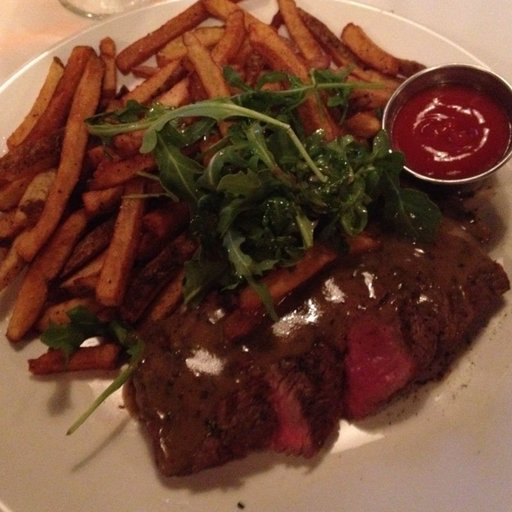

In [32]:
import random
from PIL import Image
random.seed(234)
#image path
image_path_list=list(image_path.glob("*/*/*.jpg"))

random_image_path=random.choice(image_path_list)
image_class=random_image_path.parent.stem
img=Image.open(random_image_path)
print(random_image_path)
print(image_class)
img

Text(0.5, 1.0, 'Image class: steak | Image shape: (512, 512, 3) -> [height, width, color_channels]')

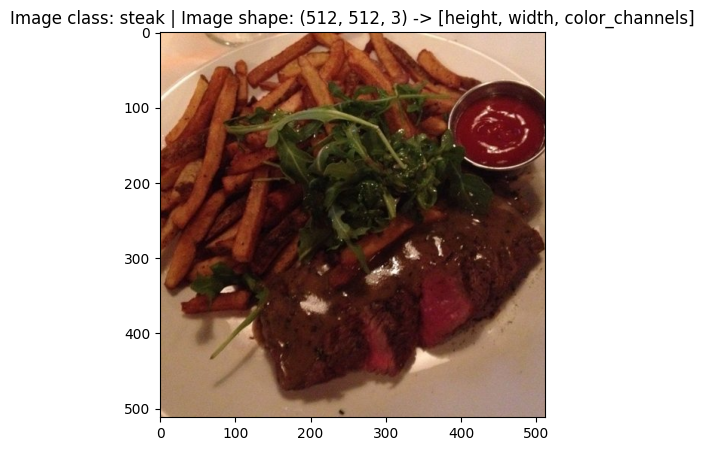

In [38]:
import numpy as np
import matplotlib.pyplot as plt
img_as_array=np.array(img)
plt.figure(figsize=(7,5))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")


In [39]:
from torchvision import datasets, transforms
data_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

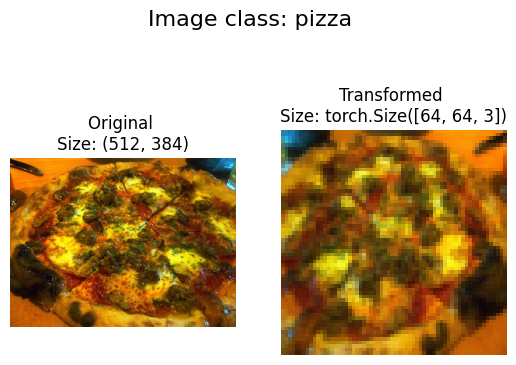

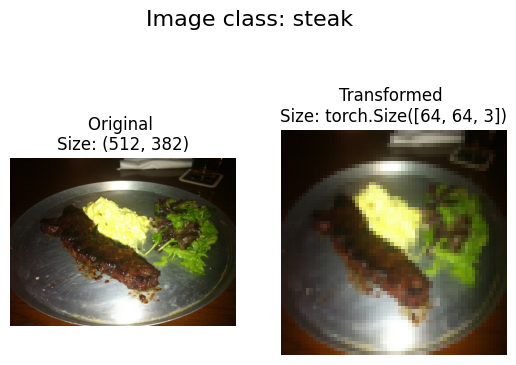

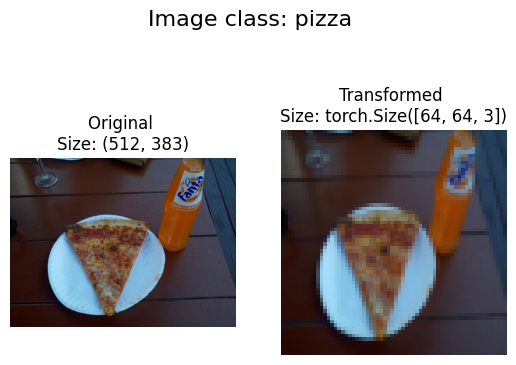

In [41]:
def plot_transformed_image(image_paths, transform, n=3, seed=420):
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis('off')

            transformed_image = transform(f).permute(1, 2, 0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis('off')

            fig.suptitle(f"Image class: {image_path.parent.stem}", fontsize=16)


plot_transformed_image(image_path_list, transform=data_transform, n=3)


In [ ]:
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir, # target folder of images
                                  transform=data_transform, # transforms to perform on data (images)
                                  target_transform=None) # transforms to perform on labels (if necessary)

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

In [ ]:
class_names = train_data.classes
class_dict = train_data.class_to_idx
class_dict, class_names


In [ ]:
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

In [ ]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=1, # how many samples per batch?
                              num_workers=1, # how many subprocesses to use for data loading? (higher = more)
                              shuffle=True) # shuffle the data?

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=1,
                             num_workers=1,
                             shuffle=False) # don't usually need to shuffle testing data

train_dataloader, test_dataloader

In [ ]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [ ]:
target_directory = train_dir
print(f"Target directory: {target_directory}")

class_names_found = sorted([entry.name for entry in list(os.scandir(image_path / "train"))])
print(f"Class names found: {class_names_found}")

In [ ]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:

    # 1. Get the class names by scanning the target directory
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

    # 2. Raise an error if class names not found
    if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in {directory}.")

    # 3. Create a dictionary of index labels (computers prefer numerical rather than string labels)
    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    return classes, class_to_idx
find_classes(train_dir)

Create a custom Dataset to replicate ImageFolder

In [ ]:
from torch.utils.data import Dataset


class ImageFolderCustom(Dataset):
    def __init__(self, target_dir: str, transform=None):
        self.paths = list(pathlib.Path(target_dir).glob("*/*.jpg"))
        self.transform = transform
        self.classes, self.class_to_idx = find_classes(target_dir)

    def load_image(self, index: int) -> Image.Image:
        "Open an image via a path and return it."
        image_path = self.paths[index]
        return Image.open(image_path)

    def __len__(self) -> int:
        return len(self.paths)

    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        "Returns one sample of the data, data and label"
        img=self.load_image(index)
        class_names=self.paths[index].parent.name
        class_idx=self.class_to_idx[class_names]

        if self.transform:
            return self.transform(img), class_idx
        else:
            return img, class_idx

In [ ]:
train_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

# Don't augment test data, only reshape
test_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

In [ ]:
train_data_custom = ImageFolderCustom(target_dir=train_dir,
                                      transform=train_transforms)
test_data_custom = ImageFolderCustom(target_dir=test_dir,
                                     transform=test_transforms)
train_data_custom, test_data_custom